In [1]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
import seaborn as sns
import matplotlib.pyplot as plt
import json
import sqlite3
import networkx as nx
from itertools import cycle

from src.author_mapping.scripts.map_abbreviations_to_authors import map_abbreviations_to_authors

In [2]:
con = sqlite3.connect('../data/interim/articles_with_author_mapping.db')
cur = con.cursor()

In [3]:
authors, authors_frequency_score, authors_department_score, author_mapping, self_referencing_authors, remaining_abbrs = map_abbreviations_to_authors("../data/interim/articles_with_author_mapping.db")

100%|██████████| 275/275 [00:07<00:00, 37.35it/s]


Found 275 authors with both frequency and department score
Removed 3 self referencing nodes
constructed graph with 526 nodes and 454 edges
calculated new assigned graph with 391 nodes and 182 edges
author_mapping has 182 rows
after dummy removal: author_mapping has 135 rows
There are 27 abbreviations that were not matched
['ast', 'at', 'nie', 'mape', 'ttr', 'mot', 'mabe', 'beck', 'ms', 'thomas', 'th', 'haeg', 'ter vehn', 'döring', 'isc', 'grätz', 'sag', 'nag', 'roger', 'kreuz', 'dei', 'sie', 'iro', 'psz', 'cc', 'hem', 'almu']
21 abbreviations have only one edge in the old graph
remaining unmatched abbreviations ['ttr', 'mabe', 'beck', 'ms', 'haeg', 'nag']


In [77]:
full_names = authors.sample(n=15, random_state=40)["full_name"].unique().tolist()[:7]

In [78]:
full_names

['Steffi Robak',
 'Lisa Schliep',
 'Uwe Hofmann',
 'Juliane Lange',
 'Robert Nößler',
 'Andrea Schrader',
 'Reinhard Rädler']

### Create old graph before the matching algorithm

In [79]:
# get all edges for the full names
old_data = authors[authors["full_name"].isin(full_names)][["full_name", "abbreviation", "score"]]

<Figure size 640x480 with 0 Axes>

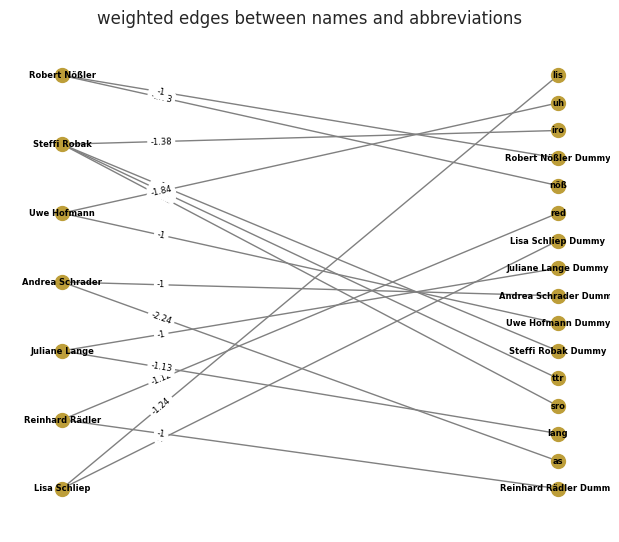

In [80]:
G = nx.Graph()
G.clear()
author_list = old_data["full_name"].unique().tolist()
abbr_list = old_data["abbreviation"].unique().tolist()
G.add_nodes_from(author_list, bipartite=0)
G.add_nodes_from(abbr_list, bipartite=1)
dummy_nodes = [f"{full_name} Dummy" for full_name in author_list]
G.add_nodes_from(dummy_nodes, bipartite=1)

edges = []
for index, row in authors[authors["full_name"].isin(author_list) & authors["abbreviation"].isin(abbr_list)].iterrows():
    G.add_edges_from([(row["full_name"], row["abbreviation"])], weight=round(row["score"],2))

for full_name in author_list:
    G.add_edges_from([(full_name, f"{full_name} Dummy")], weight=0-1)


plt.cla()
plt.clf()
# set figure size
plt.figure(figsize=(6, 5))
# plot the original graph and the solution
pos = nx.bipartite_layout(G, author_list)
nx.draw(G, pos, with_labels=True, node_size=100, node_color='#bd9e39', font_size=6, font_weight='bold', edge_color='gray')
# Add edge labels
edge_labels = nx.get_edge_attributes(G, 'weight')  # Assuming the edge weights are stored as 'weight' attribute
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=6, font_color='black', label_pos=0.8)
plt.title('weighted edges between names and abbreviations')
plt.savefig(f'../reports/figures/names_to_abbreviations_unmatched.png', dpi=300, bbox_inches='tight')
plt.show()

### Now for the matched graph

In [81]:
# get all edges for the full names
data = author_mapping[author_mapping["full_name"].isin(full_names)][["full_name", "abbreviation"]]



<Figure size 640x480 with 0 Axes>

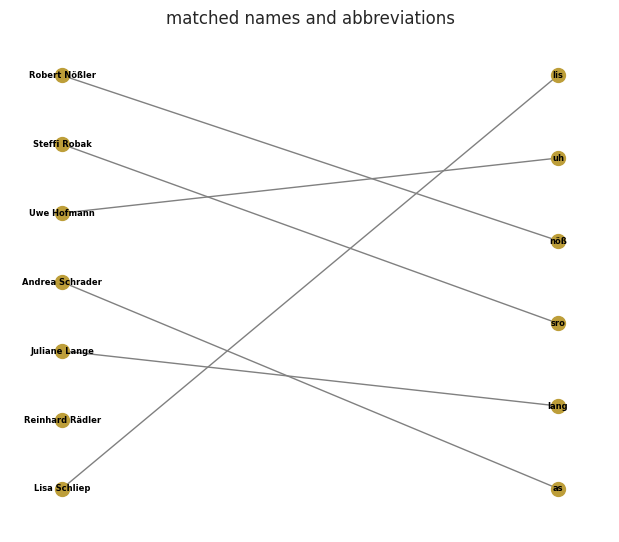

In [83]:
G = nx.Graph()
G.clear()
author_list = data["full_name"].unique().tolist()
# add nnodes of names in full_names that do not appear in mapped author_list
for full_name in full_names:
    if full_name not in author_list:
        author_list.append(full_name)
abbr_list = data["abbreviation"].unique().tolist()
G.add_nodes_from(author_list, bipartite=0)
G.add_nodes_from(abbr_list, bipartite=1)

edges = []
for index, row in author_mapping[author_mapping["full_name"].isin(author_list) & author_mapping["abbreviation"].isin(abbr_list)].iterrows():
    G.add_edges_from([(row["full_name"], row["abbreviation"])])


plt.cla()
plt.clf()
# set figure size
plt.figure(figsize=(6, 5))
# plot the original graph and the solution
pos = nx.bipartite_layout(G, author_list)
nx.draw(G, pos, with_labels=True, node_size=100, node_color='#bd9e39', font_size=6, font_weight='bold', edge_color='gray')
# Add edge labels
edge_labels = nx.get_edge_attributes(G, 'weight')  # Assuming the edge weights are stored as 'weight' attribute
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=6, font_color='black', label_pos=0.8)
plt.title('matched names and abbreviations')
plt.savefig(f'../reports/figures/names_to_abbreviations_matched.png', dpi=300, bbox_inches='tight')
plt.show()

In [68]:
author_mapping[author_mapping["abbreviation"] == "ter Vehn"]

,full_name,abbreviation
